In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
import numpy as np
from tslearn.metrics import dtw, cdist_dtw
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, average, complete
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.covariance import LedoitWolf

import networkx as nx

from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
from sklearn import preprocessing

**Load in the ETF data.**

In [2]:
ETF_data = pd.read_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/out-ETFretNEWERdates.csv",index_col=0)

In [3]:
ETF_data.index = pd.to_datetime(ETF_data.index, yearfirst=True)

In [4]:
ETF_data.head()

,ANGL,AOA,AOK,AOM,AOR,ASHR,BAB,BBH,BIL,BIV,...,XLY,XME,XMLV,XOP,XPH,XRT,XSD,XSLV,XTN,ZROZ
2014-09-24,0.002812,-0.004842,0.005850,0.004202,-3.813270e-08,0.026287,0.013656,0.038108,0.006994,0.009539,...,0.000092,-0.073457,-0.011585,-0.040176,0.007890,-0.014151,-0.004626,-0.012456,-0.016667,0.039955
2014-10-01,0.007270,-0.012619,0.004794,0.000748,-5.233600e-03,0.003514,0.023538,-0.028072,0.012553,0.022177,...,-0.016010,-0.056361,-0.004654,-0.045565,-0.020060,-0.020549,-0.036311,-0.005790,-0.027024,0.062946
2014-10-08,-0.000968,-0.001163,-0.003957,-0.003614,2.232379e-04,0.018744,-0.001835,0.003348,-0.009030,-0.000965,...,0.003689,-0.030445,0.003751,-0.052264,0.008009,0.003998,-0.021828,0.013795,-0.014620,-0.000249
2014-10-15,-0.028931,-0.044180,-0.022106,-0.026584,-3.477765e-02,-0.025064,0.003597,-0.078044,-0.008274,0.001016,...,-0.059568,-0.062250,-0.025591,-0.120739,-0.060048,-0.035232,-0.110973,-0.004802,-0.045082,0.035257
2014-10-22,0.038070,0.039399,0.024269,0.028430,3.357497e-02,0.001784,0.005373,0.102960,0.014983,0.009690,...,0.052510,0.041779,0.058124,0.036793,0.049401,0.033205,0.065079,0.034663,0.080125,-0.012111


**Create a function that calculates MST, picks up assets with degree one and calculates the average correlation and PDI index.**

In [5]:
def MinimumSpanningTree(dataset):
    corr = dataset.corr(method="spearman") #calculate the correlation
    distance_corr = (2*(1-corr))**0.5 #calculate the distance
    mask = np.triu(np.ones_like(corr, dtype=np.bool)) #get only the upper half of the matrix
    distance_corr = distance_corr*mask 
   
    #use the correlation matrix to create links
    links = distance_corr.stack().reset_index()
    links = links.replace(0, np.nan) #drop 0 values from the matrix
    links = links.dropna(how='any', axis=0)
    links.columns=["var1", "var2", "value"] #rename the columns
    links_filtered=links.loc[(links["var1"] != links["var2"])] #filter out self correlations
    
    #create the graph
    G = nx.Graph() 
    for i in range(len(corr)): # add nodes
        G.add_node(corr.index[i])
    tuples = list(links_filtered.itertuples(index=False,name=None)) #add edges with weight
    G.add_weighted_edges_from(tuples)
    
    #create a MST from the full graph 
    mst = nx.minimum_spanning_tree(G)
    
    #save the nodes with degree one
    degrees = [val for (node, val) in mst.degree()]
    df = pd.DataFrame(degrees, corr.index)
    df.columns = ["degree"]
    subset = df[df["degree"] == 1].index.tolist()
    
    #save the subset into a csv file
    #my_df = pd.DataFrame(subset)
    #my_df.to_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/MST/"+name_of_file, index=False, header=False)
    
    #Create a new dataframe with only the assets from the subset
    subset_df = dataset.loc[:, dataset.columns.isin(subset)]
    
    #calculate the average correlation of the subset
    corr_subset = subset_df.corr(method="spearman")
    corr_avg=corr_subset.mean().mean()
    
    #calculate the PDI for the subset
    pca = PCA()
    pca.fit(corr_subset)
    value = 0
    for i in range(1, corr_subset.shape[1]):
        value = value + i*pca.explained_variance_ratio_[i-1]
    PDI = 2*value - 1
    
    return subset, subset_df, corr_avg, PDI

**Now we run the function through the 17 timeperiods.**

In [6]:
beginning = "2014-09-23"  # this is the first date of the dataframe


# create a empty lists
subset1_listoflists = []
subset2_listoflists = []
subset3_listoflists = []
subset4_listoflists = []

# List for values for subset 1
PDI_list_s1=[]
average_corr_list_s1=[]
noETFs_list_s1 = []

# List for values for subset 2
PDI_list_s2=[]
average_corr_list_s2=[]
noETFs_list_s2 = []

# List for values for subset 3
PDI_list_s3=[]
average_corr_list_s3=[]
noETFs_list_s3 = []

# List for values for subset 4
PDI_list_s4=[]
average_corr_list_s4=[]
noETFs_list_s4 = []

# create a list for the dates
dates = []

for i in range(0,17):
    startdate = pd.to_datetime(beginning)+pd.DateOffset(weeks=12*i) # this is the startdate of the 97 week period
    enddate = pd.to_datetime(startdate)+pd.DateOffset(weeks=97)  # this is the enddate of the 97 week period
    dates.append(enddate.strftime("%Y/%m/%d"))
    newdataframe = ETF_data[(ETF_data.index < enddate) & (ETF_data.index > startdate)]
    
    # run the function once and save the values
    subset1_list, subset1_df, corr_avg_s1, PDI_s1 = MinimumSpanningTree(newdataframe)
    subset1_listoflists.append(subset1_list)
    PDI_list_s1.append(PDI_s1)
    average_corr_list_s1.append(corr_avg_s1)
    noETFs_list_s1.append(len(subset1_list))

    # run the function on subset 1 and save the values
    subset2_list, subset2_df, corr_avg_s2, PDI_s2 = MinimumSpanningTree(subset1_df)
    subset2_listoflists.append(subset2_list)
    PDI_list_s2.append(PDI_s2)
    average_corr_list_s2.append(corr_avg_s2)
    noETFs_list_s2.append(len(subset2_list))
    
    # run the function on subset 2 and save the values
    subset3_list, subset3_df, corr_avg_s3, PDI_s3 = MinimumSpanningTree(subset2_df)
    subset3_listoflists.append(subset3_list)
    PDI_list_s3.append(PDI_s3)
    average_corr_list_s3.append(corr_avg_s3)
    noETFs_list_s3.append(len(subset3_list))
    
    # run the function on subset 3 and save the values
    subset4_list, subset4_df, corr_avg_s4, PDI_s4 = MinimumSpanningTree(subset3_df)
    subset4_listoflists.append(subset4_list)
    PDI_list_s4.append(PDI_s4)
    average_corr_list_s4.append(corr_avg_s4)
    noETFs_list_s4.append(len(subset4_list))

    


**Make dataframes for the PDI, average correlation and number of ETFs.**

In [7]:
# PDI dataframe
PDI_list = [PDI_list_s1, PDI_list_s2, PDI_list_s3, PDI_list_s4]
PDI_df = pd.DataFrame.from_records(PDI_list).transpose()
PDI_df.index = dates
PDI_df.index = pd.to_datetime(PDI_df.index, yearfirst=True)
PDI_df = PDI_df.shift(-6,freq="D")

columns = ["Round 1", "Round 2", "Round 3", "Round 4"]
PDI_df.columns = columns

In [8]:
PDI_df

,Round 1,Round 2,Round 3,Round 4
2016-07-27,2.344425,2.944969,4.193242,4.952094
2016-10-19,2.728878,3.643755,4.761446,5.038439
2017-01-11,2.606204,3.347516,4.773762,5.146373
2017-04-05,2.747842,3.722045,4.816071,5.827388
2017-06-28,2.890225,3.887025,5.515578,6.735077
2017-09-20,3.128403,4.141441,6.643735,8.272054
2017-12-13,3.145322,4.208307,6.293340,8.026294
2018-03-07,3.472976,4.820171,7.328035,9.010580
2018-05-30,3.735899,5.037784,8.165476,8.804585
2018-08-22,3.545226,5.018153,8.132453,8.682933


In [9]:
# average correlation dataframe
avgcorr_list = [average_corr_list_s1, average_corr_list_s2, average_corr_list_s3, average_corr_list_s4 ]
corr_df = pd.DataFrame.from_records(avgcorr_list).transpose()
corr_df.index = dates
corr_df.index = pd.to_datetime(corr_df.index, yearfirst=True)
corr_df = corr_df.shift(-6,freq="D")

corr_df.columns = columns

In [10]:
corr_df

,Round 1,Round 2,Round 3,Round 4
2016-07-27,0.580344,0.533162,0.452333,0.377990
2016-10-19,0.571410,0.497845,0.431892,0.342355
2017-01-11,0.569203,0.498687,0.429288,0.366055
2017-04-05,0.533279,0.468114,0.410169,0.363743
2017-06-28,0.510694,0.449604,0.393692,0.318256
2017-09-20,0.476774,0.401590,0.324353,0.256923
2017-12-13,0.474694,0.394484,0.320548,0.267364
2018-03-07,0.434278,0.371499,0.273561,0.240132
2018-05-30,0.439952,0.370433,0.302560,0.243115
2018-08-22,0.394893,0.322656,0.281470,0.231940


In [11]:
# no of ETFs dataframe
noETFs_list = [noETFs_list_s1, noETFs_list_s2, noETFs_list_s3, noETFs_list_s4]
noETFs_df = pd.DataFrame.from_records(noETFs_list).transpose()
noETFs_df.index = dates
noETFs_df.index = pd.to_datetime(noETFs_df.index, yearfirst=True)
noETFs_df = noETFs_df.shift(-6,freq="D")

noETFs_df.columns = columns

**Save the lists of subsets into dataframes and load to csv files.**

In [12]:
subset1_df = pd.DataFrame.from_records(subset1_listoflists).transpose()#.rename(columns=dates)
subset2_df = pd.DataFrame.from_records(subset2_listoflists).transpose()#.rename(columns=dates)
subset3_df = pd.DataFrame.from_records(subset3_listoflists).transpose()#.rename(columns=dates)
subset4_df = pd.DataFrame.from_records(subset4_listoflists).transpose()#.rename(columns=dates)

# change the axis, the date is 6 days after the last date of the training priod
subset1_df.columns = PDI_df.index
subset2_df.columns = PDI_df.index
subset3_df.columns = PDI_df.index
subset4_df.columns = PDI_df.index

subset1_df.to_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/MST/out-subsets1.csv")
subset2_df.to_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/MST/out-subsets2.csv")
subset3_df.to_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/MST/out-subsets3.csv")
subset4_df.to_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/MST/out-subsets4.csv")

In [13]:
subset1_df

,2016-07-27,2016-10-19,2017-01-11,2017-04-05,2017-06-28,2017-09-20,2017-12-13,2018-03-07,2018-05-30,2018-08-22,2018-11-14,2019-02-06,2019-05-01,2019-07-24,2019-10-16,2020-01-08,2020-04-01
0,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL,ANGL
1,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,ASHR,AOK,ASHR,BIV
2,BIV,BAB,BAB,BAB,BAB,BAB,BAB,BAB,BAB,BAB,BAB,BAB,BAB,BAB,ASHR,BAB,BNDX
3,BKLN,BBH,BBH,BBH,BBH,BBH,BBH,BBH,BBH,BBH,BNDX,BNDX,BNDX,BNDX,BAB,BKLN,BOND
4,BNDX,BIV,BNDX,BNDX,BNDX,BKLN,BIV,BNDX,BIL,BNDX,BOND,BOND,BOND,BOND,BNDX,BNDX,BRF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,None,None,None,None,None,None,XPH,None,None,None,None,None,None,None,None,None,None
220,None,None,None,None,None,None,XRT,None,None,None,None,None,None,None,None,None,None
221,None,None,None,None,None,None,XSD,None,None,None,None,None,None,None,None,None,None
222,None,None,None,None,None,None,XSLV,None,None,None,None,None,None,None,None,None,None


**Plot the PDI development.**

<Figure size 1440x1080 with 0 Axes>

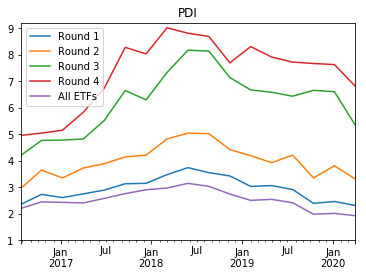

In [21]:
plt.figure(figsize=(20,15))
PDI_df.plot(kind="line")
plt.title("PDI")
plt.ylim(1,9.2)
#plt.legend(["ETF"],["Index"])
#plt.ylabel("Return [%]", fontsize=16)
#plt.xlabel("Standard Deviation", fontsize =16)
plt.show()


(0.15, 0.7)

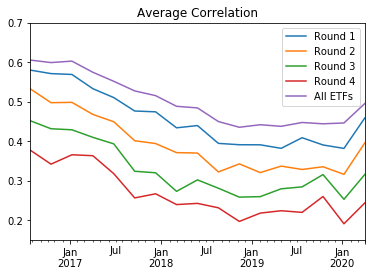

In [22]:
corr_df.plot(kind="line")
plt.title("Average Correlation")
plt.ylim(0.15,0.7)

Text(0.5, 1.0, 'No of ETFs')

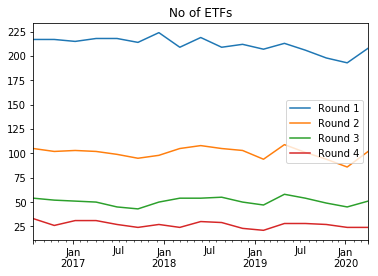

In [14]:
noETFs_df.plot(kind="line")
plt.title("No of ETFs")

In [16]:
noETFs_df.mean()

Round 1    211.588235
Round 2    100.647059
Round 3     50.705882
Round 4     26.882353
dtype: float64

In [18]:
def PDI(returnassets):   
    #calculate the correlation distance
    corr = returnassets.corr(method="spearman") 
    
    #calculate the avergae correlation
    average_corr = corr.mean().mean()
    
    #calculate the PDI index
    pca = PCA()
    pca.fit(corr)

    value = 0
    for i in range(1, corr.shape[1]):
        value = value + i*pca.explained_variance_ratio_[i-1]
    
    PDI = 2*value - 1

    
    return PDI, average_corr

In [19]:
beginning = "2014-09-23"  # this is the first date of the dataframe

PDI_list=[]
average_corr_list=[]

for i in range(0,17):
    startdate = pd.to_datetime(beginning)+pd.DateOffset(weeks=12*i) # this is the startdate of the 97 week period
    enddate = pd.to_datetime(startdate)+pd.DateOffset(weeks=97)  # this is the enddate of the 97 week period

    newdataframe = ETF_data[(ETF_data.index < enddate) & (ETF_data.index > startdate)]
    
    PDI_value, average_corr = PDI(newdataframe)
    PDI_list.append(PDI_value)
    average_corr_list.append(average_corr)

In [20]:
PDI_df["All ETFs"] = PDI_list
corr_df["All ETFs"] = average_corr_list


In [12]:
corr_data = pd.read_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/ClusteringTesting/out-Corr_df.csv", index_col=0)
PDI_data = pd.read_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/ClusteringTesting/out-PDI.csv", index_col=0)
noETFs_data = pd.read_csv("/Users/a/Dropbox/Thesis/Thesis/Coding/PreprocessedData/ClusteringTesting/out-noETFs.csv", index_col=0)


In [27]:
corr_data=corr_data.join(corr_df)

In [26]:
PDI_data = PDI_data.join(PDI_df)

In [19]:
noETFs_data=noETFs_data.join(noETFs_df)

In [20]:
noETFs_data.mean()

3X3         21.235294
3X4         27.705882
3X5         34.294118
4X3         26.000000
4X4         33.764706
4X5         41.647059
5X3         31.176471
5X4         40.529412
5X5         49.941176
Round 1    211.588235
Round 2    100.647059
Round 3     50.705882
Round 4     26.882353
dtype: float64

Pick those columns: 3x4, Round 4, 5x5, Round 3

In [24]:
no_ETFs_data=noETFs_data[["3X4","Round 4", "5X5", "Round 3"]]

Text(0.5, 1.0, 'No of ETFs')

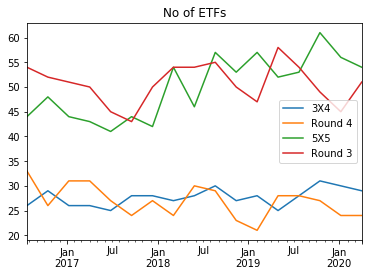

In [25]:
no_ETFs_data.plot(kind="line")
plt.title("No of ETFs")

In [28]:
PDI_data=PDI_data[["3X4","Round 4", "5X5", "Round 3"]]

Text(0.5, 1.0, 'PDI')

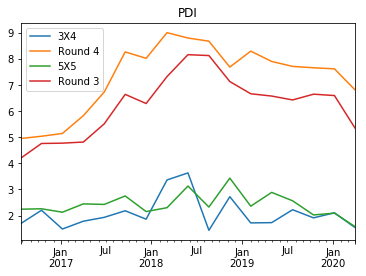

In [31]:
PDI_data.plot(kind="line")
plt.title("PDI")

In [32]:
corr_data=corr_data[["3X4","Round 4", "5X5", "Round 3"]]

Text(0.5, 1.0, 'Average Correlation')

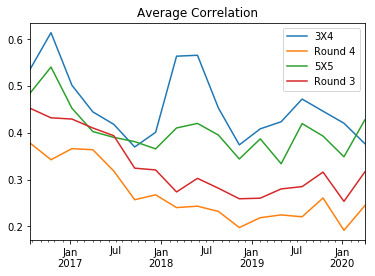

In [33]:
corr_data.plot(kind="line")
plt.title("Average Correlation")